<h1>06 赛题实践<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#代码构建" data-toc-modified-id="代码构建-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>代码构建</a></span><ul class="toc-item"><li><span><a href="#整体框架说明" data-toc-modified-id="整体框架说明-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>整体框架说明</a></span></li><li><span><a href="#算法包及全局变量" data-toc-modified-id="算法包及全局变量-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>算法包及全局变量</a></span></li><li><span><a href="#工具函数" data-toc-modified-id="工具函数-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>工具函数</a></span></li><li><span><a href="#训练及结果输出" data-toc-modified-id="训练及结果输出-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>训练及结果输出</a></span></li><li><span><a href="#算法分析" data-toc-modified-id="算法分析-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>算法分析</a></span></li><li><span><a href="#调参" data-toc-modified-id="调参-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>调参</a></span></li><li><span><a href="#整合及输出结果" data-toc-modified-id="整合及输出结果-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>整合及输出结果</a></span></li></ul></li><li><span><a href="#赛题实践" data-toc-modified-id="赛题实践-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>赛题实践</a></span><ul class="toc-item"><li><span><a href="#结果生成" data-toc-modified-id="结果生成-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>结果生成</a></span></li><li><span><a href="#绘制学习曲线" data-toc-modified-id="绘制学习曲线-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>绘制学习曲线</a></span></li><li><span><a href="#参数调优" data-toc-modified-id="参数调优-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>参数调优</a></span></li></ul></li></ul></div>

# 代码构建

## 整体框架说明

代码结构说明：  
代码采用分层架构，包括：  
工具函数，算法调用  
集成函数  

支持方便的特征读取，画学习曲线，网格调参，结果验证、输出等  

输出文件名：特征版本+算法keyword+线下成绩+时间  

这个代码结构的优点是：  
1，便于灵活调整  
2，利于复现成绩  
3，减少重复逻辑，整体代码量较少  
4，便于后续编写脚本自动执行多个实验    

## 算法包及全局变量

In [1]:
from sklearn import metrics  
import numpy as np  
import pandas as pd
import datetime
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
#########部分SKLearn 集成的算法###############
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree  
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB 
import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline
#########SKLearn 集成的算法###############
############全局参数#################################
id_col_names=['user_id','coupon_id','date_received']
target_col_name='label'
id_target_cols=['user_id','coupon_id','date_received','label']
myeval='roc_auc'
pred_result_col='predicted'
#cvscore=0
############目录定义#################################
datapath = '../data/' 
featurepath = '../data/feature/' 
resultpath = '../data/result/'
tmppath = '../data/tmp/'
scorepath = '../data/score/'

## 工具函数

In [2]:
###########工具函数#############################################
#返回ID列
def get_id_df(df):
    return df[id_col_names]

#返回Target列
def get_target_df(df):
    return df[target_col_name]

#返回特征列
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]

#按特征名读取训练集
def read_featurefile_train(featurename): 
    df=pd.read_csv(featurepath+'train_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

#按特征名读取测试集
def read_featurefile_test(featurename): 
    df=pd.read_csv(featurepath+'test_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

# 将特征归一化
def standize_df(train_data,test_data):
    from sklearn import preprocessing 
    
    features_columns = [f for f in test_data.columns if f not in id_target_cols]
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(train_data[features_columns])
    
    train_data_scaler = min_max_scaler.transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.transform(test_data[features_columns])
    
    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns
    
    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns
    
    train_data_scaler['label'] = train_data['label']
    train_data_scaler[id_col_names] = train_data[id_col_names]
    test_data_scaler[id_col_names] = test_data[id_col_names]
    return train_data_scaler,test_data_scaler

#按特征名读取数据
def read_data(featurename): 
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    #return traindf,testdf  
    return standize_df(traindf,testdf)  

## 训练及结果输出

In [3]:
####################使用sklearn的统一代码框架##########################
#提供的函数包括：
#classifier_single(featurename,classifier,cvnum)
#按满减情况分别预测
#classifier_single_sep_fd(featurename,classifier,cvnum): 
####################整合在sklearn的分类算法###############
def get_sklearn_model(model_name,param=None):
    #朴素贝叶斯
    if model_name=='NB':
        model = MultinomialNB(alpha=0.01)
    #逻辑回归
    elif model_name=='LR':
        model = LogisticRegression(penalty='l2') 
    # KNN  
    elif model_name=='KNN':
        model = KNeighborsClassifier()  
    #随机森林
    elif model_name=='RF':
        model = RandomForestClassifier()  
    #决策树
    elif model_name=='DT':
        model = tree.DecisionTreeClassifier()  
    #向量机
    elif model_name=='SVC':
        model = SVC(kernel='rbf')
    #GBDT
    elif model_name=='GBDT':
        model = GradientBoostingClassifier()
    #XGBoost
    elif model_name=='XGB':
        model = XGBClassifier()
    #lightGBM
    elif model_name=='LGB':
        model = LGBMClassifier()
    else:
        print("wrong model name!")
        return
    if param is not None:
        model.set_params(**param)
    return model
    

#性能评价函数
#本赛题目标是预测投放的优惠券是否核销。
#针对此任务及一些相关背景知识，使用优惠券核销预测的平均AUC（ROC曲线下面积）作为评价标准。 
#即对每个优惠券coupon_id单独计算核销预测的AUC值，再对所有优惠券的AUC值求平均作为最终的评价标准。
# coupon平均auc计算
def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        coupon_df = i[1]
        #测算AUC必须大于1个类别
        if len(coupon_df['label'].unique()) < 2:
            continue
        auc = metrics.roc_auc_score(coupon_df['label'], coupon_df['predicted'])
        aucs.append(auc)
    return np.average(aucs)

#预测方式：按照购买概率进行预测
def proba_predict(model,df):
    pred = model.predict_proba(df)
    return pred[:,1] 

#预测，
def classifier_pred(traindf,classifier,param=None):
    model = get_sklearn_model(classifier,param)
    if classifier in ['LGB']:
        model.fit(get_predictors_df(traindf), get_target_df(traindf),eval_metric=myeval)
    if classifier in ['XGB']:
        model.fit(get_predictors_df(traindf), get_target_df(traindf),eval_metric='auc')
    else:
        model.fit(get_predictors_df(traindf), get_target_df(traindf))
    return model

#不分折进行预测
def fit_once(train_feat, test_feat,classifier,param=None):
    model=classifier_pred(train_feat,classifier,param)
    predicted = pd.DataFrame(proba_predict(model,get_predictors_df(test_feat)))
    return predicted,get_target_df(train_feat)

#分折进行预测
def fit_cv(train_feat, test_feat,classifier,cvnum,param=None):       
    print('开始CV '+str(cvnum)+'折训练...')
    train_preds = np.zeros(train_feat.shape[0])
    test_preds = np.zeros((test_feat.shape[0], cvnum))
    i=0
    kf = StratifiedKFold(n_splits = cvnum, shuffle=True, random_state=520)
    for train_index, test_index in kf.split(get_predictors_df(train_feat),get_target_df(train_feat)):
        print('第{}次训练...'.format(i+1))
        train_feat1 = train_feat.iloc[train_index]
        train_feat2 = train_feat.iloc[test_index]
        model=classifier_pred(train_feat1,classifier,param)
        
        train_preds[test_index] += proba_predict(model,get_predictors_df(train_feat2))
        test_preds[:,i] = proba_predict(model,get_predictors_df(test_feat))
        i=i+1
    
#    print('CV训练用时{}秒'.format(time.time() - t0))
    test_y=test_preds.mean(axis=1)    
    #test_y_1 = pd.Series(test_y).apply(lambda x : 1 if x>0.5 else 0)
    #submission = pd.DataFrame({'pred':test_preds.mean(axis=1)})
    return pd.DataFrame(test_y),pd.DataFrame(train_preds)


def classifier_df(train_feat, test_feat,classifier,cvnum,param=None): 
    if cvnum<=1:
        predicted,train_preds = fit_once(train_feat, test_feat,classifier,param)
    else:
        predicted,train_preds = fit_cv(train_feat,test_feat,classifier,cvnum,param)
    print('output')
    #predicted=predicted.round(3)
    return predicted,train_preds

#输出结果
def output_predicted(predicted,resultfile,test_feat):
    predicted=round(predicted,3)
    resultdf=get_id_df(test_feat).copy()
    resultdf['Probability']=predicted
    resultdf.to_csv(resultfile,header=False,index=False,sep=',')

#预测函数
def classifier_df_simple(train_feat, test_feat,classifier,param=None):
    model = get_sklearn_model(classifier,param)    
    model.fit(get_predictors_df(train_feat), get_target_df(train_feat))    
    predicted = pd.DataFrame(model.predict_proba(get_predictors_df(test_feat))[:,1])
    return predicted

## 算法分析

In [4]:
########################训练曲线################################################
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=[0.005,0.01,0.02,0.04,0.1,0.2,0.5]):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv,scoring=myeval, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt

#画算法的学习曲线,为加快画图速度，最多选30%数据
def plot_curve_single(featurename,classifier,cvnum,train_sizes=[0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.3]): 
    traindf,testdf= read_data(featurename)
    X=get_predictors_df(traindf)
    y=get_target_df(traindf)
    title = "learning curve of feature:"+featurename+", model "+classifier+", cv:"+str(cvnum)
    estimator = get_sklearn_model(classifier)    #建模
    plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cvnum, train_sizes=train_sizes)
##########################算法分析###############################################  
#对算法进行分析整体AUC
def classifier_df_score_auc(train_x,train_y,classifier,cvnum,param=None):
    from sklearn.model_selection import cross_val_score
    model=get_sklearn_model(classifier,param)
    #loss  = make_scorer(my_custom_loss_func, greater_is_better=False)
    #score = make_scorer(my_custom_loss_func, greater_is_better=True)
    scores = cross_val_score(model,train_x,train_y,scoring=myeval,cv=cvnum)
    return scores
    
def classifier_single_score(featurename,classifier,cvnum,param=None): 
    print('reading training data...')
    traindf,testdf= read_data(featurename)
    train_x=get_predictors_df(traindf)
    train_y=get_target_df(traindf)
    scores=classifier_df_score(train_x,train_y,classifier,cvnum,param)
    print(scores)
    print(classifier+":")
    print(scores.mean())
 
#对算法进行分析Coupon AUC
def classifier_df_score(train_feat,classifier,cvnum,param=None):  
    clf=get_sklearn_model(classifier,param)
    train = train_feat.copy()
    target = get_target_df(train_feat).copy()
    kf = StratifiedKFold(n_splits=cvnum)
    
    scores=[]
    score_coupons=[]
    for k, (train_index, test_index) in enumerate(kf.split(train,target)):
        train_data,test_data,train_target,test_target = train.iloc[train_index],train.iloc[test_index],target[train_index],target[test_index]
        clf.fit(get_predictors_df(train_data), train_target) 
        
        test_pred=clf.predict_proba(get_predictors_df(test_data))[:,1]
        
        score_test = metrics.roc_auc_score(test_target, test_pred)
        test_data[pred_result_col]=test_pred
        score_coupon_test=myauc(test_data)
        
        scores.append(score_test)
        score_coupons.append(score_coupon_test)
        
    print (classifier+"总体AUC:",scores)
    print (classifier+"Coupon AUC:",score_coupons)

## 调参

In [5]:
##########################网格调参###############################################
#对进行网格调参
def grid_search(train_feat, test_feat,classifier,cvnum,search_scope,param=None):
    parameters= search_scope
    clf = GridSearchCV(get_sklearn_model(classifier,param), 
        param_grid=parameters,scoring='roc_auc',verbose=2)
    clf.fit(get_predictors_df(train_feat), get_target_df(train_feat))
    print("最优参数")
    print(clf.best_params_)
    
    test_df=get_predictors_df(test_feat)
    predicted = pd.DataFrame(clf.predict(test_df))
    return predicted

def grid_search_single(featurename,classifier,cvnum,search_scope,param=None):
    train_feat,test_feat= read_data(featurename)
    predicted=grid_search(train_feat, test_feat,classifier,cvnum,search_scope,param)
    resultfile=resultpath+featurename+'_'+str(cvnum)+'_'+classifier+'_grid_'+format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))+'.csv'
    output_predicted(predicted,resultfile,test_feat)
    
#对进行网格调参
def grid_plot(train_feat,classifier,cvnum,param_range,param_name,param=None):
    from sklearn.model_selection import validation_curve
    train_scores, test_scores = validation_curve(
        get_sklearn_model(classifier,param), get_predictors_df(train_feat), get_target_df(train_feat), param_name=param_name, param_range=param_range,
        cv=cvnum, scoring='roc_auc', n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title("Validation Curve with "+param_name)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

def grid_plot_single(featurename,classifier,cvnum,param_range,param_name,param=None):
    train_feat,test_feat= read_data(featurename)
    grid_plot(train_feat,classifier,cvnum,param_range,param_name,param=None)

## 整合及输出结果

In [6]:
######################以下为最终输出函数##########################################
#只运行一种算法
def classifier_single(featurename,classifier,cvnum,param=None): 
    traindf,testdf= read_data(featurename)
    
    predicted,train_preds=classifier_df(traindf,testdf,classifier,cvnum,param)
    
    if cvnum>1:
        traindf[pred_result_col]=train_preds    
        score =myauc(traindf)
        print('线下成绩：    {}'.format(score))
        resultfile=resultpath+featurename+'_'+str(cvnum)+'_'+classifier+'_'+format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))+'_'+str(round(score,3))+'.csv'
    else:
        resultfile=resultpath+featurename+'_'+str(cvnum)+'_'+classifier+'_'+format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))+'.csv'
    output_predicted(predicted,resultfile,testdf)

# 平均融合classifier_multi的一种融合方式，可以写多个类似的,作为classifier_multi的参数
def multi_mean(train_multi,test_multi,pred_names):
    i=0
    for pred in pred_names:
        i=i+1
        if i==1:
            train_multi[pred_result_col]=train_multi[pred]
            test_multi[pred_result_col]=test_multi[pred]
        else:
            train_multi[pred_result_col]=train_multi[pred_result_col]+train_multi[pred]
            test_multi[pred_result_col]=train_multi[pred_result_col]+test_multi[pred]
    train_multi[pred_result_col]=train_multi[pred_result_col]/i
    test_multi[pred_result_col]=test_multi[pred_result_col]/i
    return train_multi,test_multi
   
#运行多种算法
#sum_func为对多种算法结果的整合函数，要求最终的输出列为'predicted'
def classifier_multi(featurename,classifiers,cvnum,sum_func,param=None): 
    traindf,testdf= read_data(featurename)
    train_multi=traindf.copy()
    test_multi=testdf.copy()
    
    notes=''
    pred_names=[]
    
    for classifier in classifiers:
        print('开始'+classifier+'训练')
        notes=notes+'-'+classifier
        pred_names.append(classifier+'_pred')
        predicted,train_preds=classifier_df(traindf,testdf,classifier,cvnum,param)
        train_multi[classifier+'_pred']=train_preds
        test_multi[classifier+'_pred']=predicted
    
    train_result,test_result=sum_func(train_multi,test_multi,pred_names)

    #score = metrics.roc_auc_score(get_target_df(train_result),train_result['predicted'])
    #print('线下得分：    {}'.format(score))
    
    score =myauc(train_result)
    print('线下成绩：    {}'.format(score))

    if cvnum>1:
        resultfile=resultpath+featurename+'_'+str(cvnum)+'_'+notes+'_'+format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))+'_'+str(round(score,3))+'.csv'
    else:
        resultfile=resultpath+featurename+'_'+str(cvnum)+'_'+notes+'_'+format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))+'.csv'
    
    output_predicted(test_result['predicted'],resultfile,test_result)

#按满减情况分别预测
def classifier_single_sep_fd(featurename,classifier,cvnum,param=None): 
    trainalldf,testalldf= read_data(featurename)
    test_result=pd.DataFrame()
    train_result=pd.DataFrame()
    #按满减情况分类
    for fd in range(0,2):
        traindf=trainalldf[trainalldf.if_fd==fd].copy()
        testdf=testalldf[testalldf.if_fd==fd].copy()
       
        predicted,train_preds=classifier_df(traindf,testdf,classifier,cvnum,param)
        predicted=round(predicted,3)

        if fd==0:
            test_result=get_id_df(testdf).copy().reset_index(drop=True)
            test_result['predicted']=predicted
            
            train_result=traindf.copy().reset_index(drop=True)
            train_result['predicted']=train_preds
            
        else:
            dft1=get_id_df(testdf).copy().reset_index(drop=True)
            dft1['predicted']=predicted
            test_result=pd.concat([test_result,dft1], axis=0).reset_index(drop=True)
            
            dfv1=traindf.copy().reset_index(drop=True)
            dfv1['predicted']=train_preds
            train_result=pd.concat([train_result,dfv1], axis=0).reset_index(drop=True)

    if cvnum>1:
        #score = metrics.roc_auc_score(get_target_df(train_result),train_result['predicted'])
        score = round(myauc(train_result),3)
        print('线下得分：    {}'.format(score))    
        resultfile=resultpath+featurename+'_sepfd_'+str(cvnum)+'_'+classifier+'_'+str(score)+'.csv'
    else:
        resultfile=resultpath+featurename+'_sepfd_'+str(cvnum)+'_'+classifier+'.csv'
    test_result.to_csv(resultfile,header=False,index=False,sep=',')

# 赛题实践

## 结果生成

In [7]:
# 采用f2版本特征，LightGBM，5折，默认参数
classifier_single('sf2','LGB',5)

开始CV 5折训练...
第1次训练...
第2次训练...
第3次训练...
第4次训练...
第5次训练...
output
线下成绩：    0.5924994757022239


线上成绩auc:0.63080446


In [8]:
# 采用f3版本特征，LightGBM，5折，默认参数
classifier_single('sf3','LGB',5)

开始CV 5折训练...
第1次训练...
第2次训练...
第3次训练...
第4次训练...
第5次训练...
output
线下成绩：    0.7352683078277721


线上成绩auc:0.77181277说明穿越特征很好用！！！  
**一个比赛是否能用穿越特征，一定要先与组委会确认！！！**

In [9]:
# 采用f3版本特征，LightGBM，5折，优化后参数

params={'boosting_type':'gbdt',
	    'objective': 'binary',
	    'eval_metric':'auc',
	    'n_estimators':200,
	    'max_depth':5,
	    'num_leaves':40,
	    'max_bin':400,
	    'min_data_in_leaf':120,
	    'learning_rate':0.05,
	    'lambda_l1': 1e-05,
	    'lambda_l2':1e-05,
	    'min_split_gain':0.0,
	    'bagging_freq':4,
	    'bagging_fraction': 0.9,
	    'feature_fraction':0.6,
	    'seed':1024,
	    'n_thread':12
	    }
classifier_single('sf3','LGB',5,params)

开始CV 5折训练...
第1次训练...
[LightGBM] [Warning] Unknown parameter: n_thread
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=1e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-05
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-05
第2次训练...
[LightGBM] [Warning] Unknown parameter: n_thread
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. C

线上成绩：score:0.7768 有所增长，调参还是有用的

In [10]:
# 采用f3版本特征，LightGBM+XGBoost融合，5折，默认参数
classifier_multi('sf3',['XGB','LGB'],5,multi_mean)

开始XGB训练
开始CV 5折训练...
第1次训练...
第2次训练...
第3次训练...
第4次训练...
第5次训练...
output
开始LGB训练
开始CV 5折训练...
第1次训练...
第2次训练...
第3次训练...
第4次训练...
第5次训练...
output
线下成绩：    0.730391870871715


线上成绩auc:0.72321374。XGBoost好像有点过拟了，拖累了总成绩。后续可以试一下别的融合方式，或者XGBoost调一下参

In [11]:
# 采用f3版本特征，LightGBM，5折，默认参数，根据是否为满减分别训练
classifier_single_sep_fd('sf3','LGB',5)

开始CV 5折训练...
第1次训练...
第2次训练...
第3次训练...
第4次训练...
第5次训练...
output
开始CV 5折训练...
第1次训练...
第2次训练...
第3次训练...
第4次训练...
第5次训练...
output
线下得分：    0.731


线上成绩auc:0.77653617  
说明分开训练会有少许提升

In [12]:
# 采用f3版本特征，LightGBM，5折，优化后参数，根据是否为满减分别训练

params={'boosting_type':'gbdt',
	    'objective': 'binary',
	    'eval_metric':'auc',
	    'n_estimators':200,
	    'max_depth':5,
	    'num_leaves':40,
	    'max_bin':400,
	    'min_data_in_leaf':120,
	    'learning_rate':0.05,
	    'lambda_l1': 1e-05,
	    'lambda_l2':1e-05,
	    'min_split_gain':0.0,
	    'bagging_freq':4,
	    'bagging_fraction': 0.9,
	    'feature_fraction':0.6,
	    'seed':1024,
	    'n_thread':12
	    }

classifier_single_sep_fd('sf3','LGB',5,params)

开始CV 5折训练...
第1次训练...
[LightGBM] [Warning] Unknown parameter: n_thread
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=1e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-05
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-05
第2次训练...
[LightGBM] [Warning] Unknown parameter: n_thread
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. C

## 绘制学习曲线

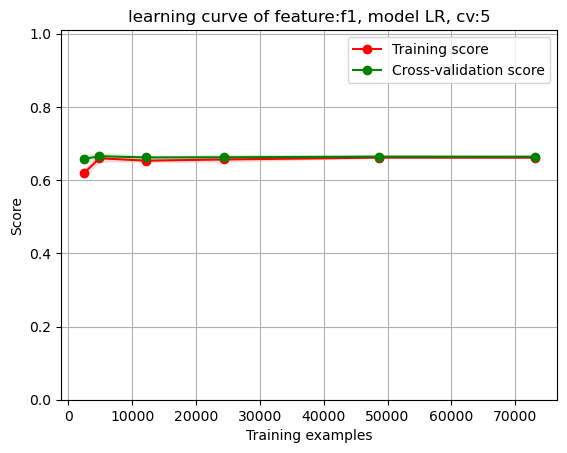

In [13]:
plot_curve_single('f1','LR',5,[0.01,0.02,0.05,0.1,0.2,0.3])

## 参数调优

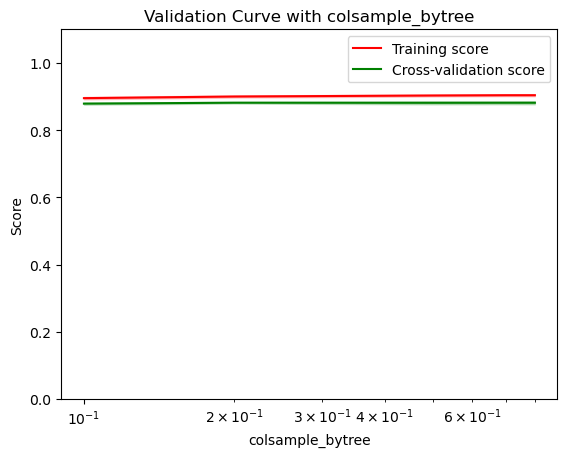

In [14]:
grid_plot_single('sf3','LGB',3,[0.1,0.2,0.5,0.7,0.8],'colsample_bytree')

In [15]:
grid_search_single('f1','LGB',5,[{'gamma':[0,0.3,0.5,0.7,0.9]}])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Warning] Unknown parameter: gamma
[CV] END ............................................gamma=0; total time=   0.6s
[LightGBM] [Warning] Unknown parameter: gamma
[CV] END ............................................gamma=0; total time=   0.6s
[LightGBM] [Warning] Unknown parameter: gamma
[CV] END ............................................gamma=0; total time=   0.6s
[LightGBM] [Warning] Unknown parameter: gamma
[CV] END ............................................gamma=0; total time=   0.6s
[LightGBM] [Warning] Unknown parameter: gamma
[CV] END ............................................gamma=0; total time=   0.6s
[LightGBM] [Warning] Unknown parameter: gamma
[CV] END ..........................................gamma=0.3; total time=   0.6s
[LightGBM] [Warning] Unknown parameter: gamma
[CV] END ..........................................gamma=0.3; total time=   0.6s
[LightGBM] [Warning] Unknown parameter: gamma
[CV] 